In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import glob

import cv2
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

629 628
Classes: 
['covid-19', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


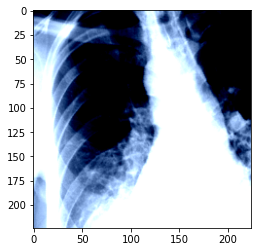

In [6]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
data_dir = '/content/drive/My Drive/A_05_Part_02_Dataset'
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/Validation', transform=test_transforms)
test_data  = datasets.ImageFolder(data_dir + '/Test', transform=test_transforms)

print(len(test_data), len(valid_data))


trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
testloader  = torch.utils.data.DataLoader(test_data,  batch_size=8, shuffle=False)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=8, shuffle=True)
dataloaders = {'train':trainloader, 'val':validloader}


print("Classes: ")
class_names = train_data.classes
print(class_names)


inputs , classs = next(iter(trainloader))
x = inputs[0]
x = x.numpy().transpose((1, 2, 0))
plt.imshow(x)



In [0]:
#VGG16 pretrained model

vgg16 = models.vgg16(pretrained=True)
vgg16.classifier = nn.Sequential( nn.Linear( vgg16.classifier[0].in_features , 300 , bias=True ), 
                             nn.ReLU( inplace=True ), 
                             nn.Dropout( p=0.5, inplace=False ), 
                             nn.Linear( 300 , 3 ) )


In [0]:
def misClassification(actual,predict):
  infected_T = np.where( (actual==0) & (predict==0) )[0]
  infected_F = np.where( (actual==0) & (predict==1) )[0]
  normal_T   = np.where( (actual==1) & (predict==1) )[0]
  normal_F   = np.where( (actual==1) & (predict==0) )[0]
  print( len(infected_T), len(infected_F), len(normal_T), len(normal_F) )

  print('Actuall   = Infected')
  print('Actuall   =  Normal')

  plt.imshow(np.array(valid_data[infected_F[0]][0]).transpose((1, 2, 0)))
  plt.title('Prediction = '+class_names[1])
  plt.show()


  print('Actuall   = Normal')
  print('Actuall   = Infected')

  plt.imshow(np.array(valid_data[normal_F[0]][0]).transpose((1, 2, 0)))
  plt.title('Prediction = '+class_names[0])
  plt.show()



def calculateF1(y_true,y_pred):
  tp = (y_true * y_pred).sum()
  tn = ((1 - y_true) * (1 - y_pred)).sum()
  fp = ((1 - y_true) * y_pred).sum()
  fn = (y_true * (1 - y_pred)).sum()
  epsilon = 1e-7

  precision = tp / (tp + fp + epsilon)
  recall    = tp / (tp + fn + epsilon)
  f1 = 2* (precision*recall) / (precision + recall + epsilon)

  print("\n precision = ",precision, "\n Recall    = ", recall, "\n F1 score = ", f1)

def confusion_mat(model,testloader ):

  classes = 3
  actual  = []
  predict = []

  confusion_matrix = torch.zeros(classes, classes)
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(testloader):
          inputs  = inputs.to(device)
          classes = classes.to(device)
          outputs = model(inputs)
          _,preds = torch.max(outputs, 1)
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1
          actual.extend( np.array(classes.cpu()) )
          predict.extend(np.array(preds.cpu()) )
      # confusion_matrix(actual, predict)
      actual  = np.array(actual)
      predict = np.array(predict)
      # misClassification(actual,predict)
      calculateF1(actual,predict)
  return confusion_matrix

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def testAccuracy(model,testloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on  test data: %d %%' % (
      100 * correct / total))
  
def plotEvaluations(trainAcc,trainErr,validAcc,validErr):
  fig,ax = plt.subplots(2,2)
  fig.set_size_inches(10,5)

  ax[0][0].plot(trainAcc)
  ax[0][0].set_title('training Accuracy')
  ax[0][0].xaxis.set_visible(False) 


  ax[0][1].plot(trainErr)
  ax[0][1].set_title('training Loss')
  ax[0][1].xaxis.set_visible(False) 


  ax[1][0].plot(validAcc)
  ax[1][0].set_title('validation Accuracy')

  ax[1][1].plot(validErr)
  ax[1][1].set_title('validation Loss')


class focal_loss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(focal_loss,self).__init__()
        self.a = alpha
        self.g = gamma
        
    def forward(self, outputs, labels):
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(outputs, labels)
        pt = torch.exp(-bce_loss)
        loss = self.a * ((1-pt)**self.g) * bce_loss
        return loss.mean()

def onehot(labels):
    arr = np.array(labels)
    out = np.zeros((arr.size, 3))
    out[np.arange(arr.size),arr] = 1
    out[out[:,0] == 1] = np.array([1,0,1])
    out = torch.Tensor(out)
    return out.to(device)


In [0]:
def train_model(model, criterion, optimizer, num_epochs=10):
    start = time.time()

    trainErr = []
    trainAcc = []
    validErr = []
    validAcc = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                labels = onehot(labels)
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    pred    = torch.sigmoid(outputs.data)
                    pred[pred>=0.5] = 1
                    pred[pred<0.5]  = 0

                    loss = criterion(outputs, labels)
                    # loss = Variable(loss, requires_grad = True)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

              
                running_loss += loss.item() * inputs.size(0)
                total += labels.size(0)
                running_corrects += (pred == labels).prod(1).sum().item()
            # if phase == 'train':
            #     scheduler.step()

            epoch_loss = running_loss / total
            epoch_acc  = running_corrects / total

            print('Epoch {}/{},{} ==> Loss: {:.4f} , Acc: {:.2f} %'.format(
                epoch+1, num_epochs,phase, epoch_loss, epoch_acc*100))
            
            
            if phase == 'train':
                trainErr.append(epoch_loss)
                trainAcc.append(epoch_acc*100)
            else:
                validErr.append(epoch_loss)
                validAcc.append(epoch_acc*100)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    endtime = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format( endtime // 60, endtime % 60))
    print('Best Validation Accuracy: {:4f} %'.format(best_acc*100))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, trainErr, trainAcc, validErr, validAcc

Epoch 1/20,train ==> Loss: 0.1915 , Acc: 69.11 %
Epoch 1/20,val ==> Loss: 0.1281 , Acc: 85.67 %

Epoch 2/20,train ==> Loss: 0.1416 , Acc: 82.13 %
Epoch 2/20,val ==> Loss: 0.1065 , Acc: 89.49 %

Epoch 3/20,train ==> Loss: 0.1273 , Acc: 84.05 %
Epoch 3/20,val ==> Loss: 0.1027 , Acc: 89.33 %

Epoch 4/20,train ==> Loss: 0.1166 , Acc: 84.68 %
Epoch 4/20,val ==> Loss: 0.0931 , Acc: 90.29 %

Epoch 5/20,train ==> Loss: 0.1130 , Acc: 85.35 %
Epoch 5/20,val ==> Loss: 0.0893 , Acc: 90.29 %

Epoch 6/20,train ==> Loss: 0.1074 , Acc: 85.68 %
Epoch 6/20,val ==> Loss: 0.0839 , Acc: 91.40 %

Epoch 7/20,train ==> Loss: 0.1033 , Acc: 86.27 %
Epoch 7/20,val ==> Loss: 0.0874 , Acc: 90.61 %

Epoch 8/20,train ==> Loss: 0.1013 , Acc: 87.32 %
Epoch 8/20,val ==> Loss: 0.0861 , Acc: 90.45 %

Epoch 9/20,train ==> Loss: 0.0972 , Acc: 87.42 %
Epoch 9/20,val ==> Loss: 0.0782 , Acc: 91.72 %

Epoch 10/20,train ==> Loss: 0.0981 , Acc: 87.65 %
Epoch 10/20,val ==> Loss: 0.0903 , Acc: 88.38 %

Epoch 11/20,train ==> Loss: 

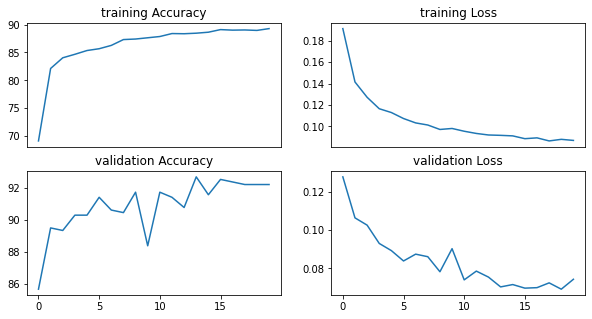

In [7]:
Epochs = 20
criterion = focal_loss(alpha=1, gamma=1)
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    vgg16.cuda()
model, trainErr, trainAcc, validErr, validAcc = train_model( vgg16, criterion, optimizer, Epochs  )
torch.save(model, '/content/drive/My Drive/Vgg16_CE_entire.pth')

# testAccuracy(model,testloader)
plotEvaluations(trainAcc,trainErr,validAcc,validErr)



Epoch 1/20,train ==> Loss: 0.0324 , Acc: 88.45 %
Epoch 1/20,val ==> Loss: 0.0259 , Acc: 92.20 %

Epoch 2/20,train ==> Loss: 0.0318 , Acc: 88.90 %
Epoch 2/20,val ==> Loss: 0.0259 , Acc: 91.56 %

Epoch 3/20,train ==> Loss: 0.0313 , Acc: 89.42 %
Epoch 3/20,val ==> Loss: 0.0251 , Acc: 92.52 %

Epoch 4/20,train ==> Loss: 0.0309 , Acc: 88.89 %
Epoch 4/20,val ==> Loss: 0.0280 , Acc: 91.72 %

Epoch 5/20,train ==> Loss: 0.0315 , Acc: 89.10 %
Epoch 5/20,val ==> Loss: 0.0255 , Acc: 91.88 %

Epoch 6/20,train ==> Loss: 0.0315 , Acc: 89.24 %
Epoch 6/20,val ==> Loss: 0.0264 , Acc: 91.88 %

Epoch 7/20,train ==> Loss: 0.0305 , Acc: 89.50 %
Epoch 7/20,val ==> Loss: 0.0296 , Acc: 91.40 %

Epoch 8/20,train ==> Loss: 0.0304 , Acc: 88.95 %
Epoch 8/20,val ==> Loss: 0.0260 , Acc: 92.04 %

Epoch 9/20,train ==> Loss: 0.0311 , Acc: 89.34 %
Epoch 9/20,val ==> Loss: 0.0267 , Acc: 91.88 %

Epoch 10/20,train ==> Loss: 0.0303 , Acc: 89.60 %
Epoch 10/20,val ==> Loss: 0.0243 , Acc: 92.52 %

Epoch 11/20,train ==> Loss: 

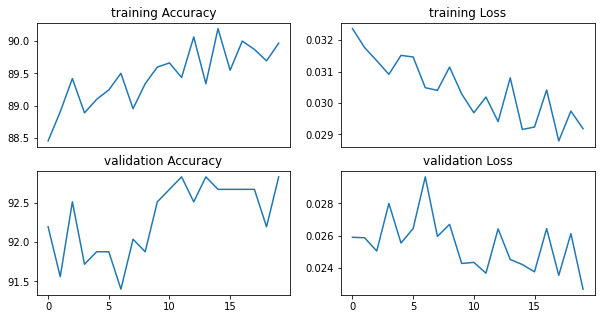

In [8]:
Epochs = 20
criterion = focal_loss(alpha=0.5, gamma=1.5)
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    vgg16.cuda()
model, trainErr, trainAcc, validErr, validAcc = train_model( vgg16, criterion, optimizer, Epochs  )
torch.save(model, '/content/drive/My Drive/Vgg16_FL_entire1.pth')

# testAccuracy(model,testloader)
plotEvaluations(trainAcc,trainErr,validAcc,validErr)



Epoch 1/20,train ==> Loss: 0.1054 , Acc: 62.89 %
Epoch 1/20,val ==> Loss: 0.0746 , Acc: 84.55 %

Epoch 2/20,train ==> Loss: 0.0816 , Acc: 77.97 %
Epoch 2/20,val ==> Loss: 0.0653 , Acc: 86.15 %

Epoch 3/20,train ==> Loss: 0.0727 , Acc: 80.92 %
Epoch 3/20,val ==> Loss: 0.0599 , Acc: 88.54 %

Epoch 4/20,train ==> Loss: 0.0673 , Acc: 82.74 %
Epoch 4/20,val ==> Loss: 0.0591 , Acc: 88.69 %

Epoch 5/20,train ==> Loss: 0.0640 , Acc: 84.23 %
Epoch 5/20,val ==> Loss: 0.0523 , Acc: 89.65 %

Epoch 6/20,train ==> Loss: 0.0615 , Acc: 84.63 %
Epoch 6/20,val ==> Loss: 0.0509 , Acc: 90.13 %

Epoch 7/20,train ==> Loss: 0.0599 , Acc: 85.03 %
Epoch 7/20,val ==> Loss: 0.0494 , Acc: 90.61 %

Epoch 8/20,train ==> Loss: 0.0566 , Acc: 85.94 %
Epoch 8/20,val ==> Loss: 0.0612 , Acc: 83.28 %

Epoch 9/20,train ==> Loss: 0.0557 , Acc: 85.90 %
Epoch 9/20,val ==> Loss: 0.0491 , Acc: 90.76 %

Epoch 10/20,train ==> Loss: 0.0540 , Acc: 86.26 %
Epoch 10/20,val ==> Loss: 0.0541 , Acc: 90.61 %

Epoch 11/20,train ==> Loss: 

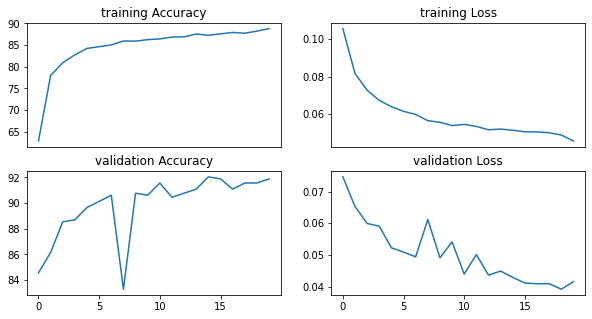

In [16]:
Epochs = 20
criterion = focal_loss(alpha=1, gamma=2)
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    vgg16.cuda()
model, trainErr, trainAcc, validErr, validAcc = train_model( vgg16, criterion, optimizer, Epochs  )
torch.save(model, '/content/drive/My Drive/Vgg16_FL_entire2.pth')

# testAccuracy(model,testloader)
plotEvaluations(trainAcc,trainErr,validAcc,validErr)



In [0]:
def onehot(labels):
    arr = np.array(labels)
    out = np.zeros((arr.size, 3))
    out[np.arange(arr.size),arr] = 1
    out[out[:,0] == 1] = np.array([1,0,1])
    return out

def feedforward(model,testloader):
  actual  = []
  predict = []
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(testloader):
          inputs  = inputs.to(device)
          classes = classes.to(device)
          outputs = model(inputs)
          preds   = torch.sigmoid(outputs)

          actual.extend( np.array(classes.cpu()) )
          predict.extend(np.array(preds.cpu()) )
      actual  = np.array(actual)
      predict = np.array(predict)
      actual  = onehot(actual)
      predict[predict>=0.5] = 1
      predict[predict<0.5]  = 0
  return actual, predict
def confusion_mat(actual , predict ):

  classes = 3
  confusion_matrix = torch.zeros(classes, classes)

  for t, p in zip(actual, predict):
      confusion_matrix[t.argmax(), p.argmax()] += 1
  
  total = predict.shape[0]
  correct = (predict == actual).all(1).sum().item()
  print('Accuracy = %d %%' % ( 100 * correct / total))

  cm =  multilabel_confusion_matrix(actual,predict)
  print( skm.classification_report(actual,predict))
  f1 = f1_score(actual, predict, average='macro')
  print("F1 score = ", f1)
  print(cm)
  print(confusion_matrix)
  return confusion_matrix

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



 

Accuracy = 87 %
              precision    recall  f1-score   support

           0       0.79      0.34      0.47       200
           1       0.94      0.91      0.92      4000
           2       0.85      0.89      0.87      2200

   micro avg       0.90      0.89      0.89      6400
   macro avg       0.86      0.71      0.75      6400
weighted avg       0.90      0.89      0.89      6400
 samples avg       0.90      0.90      0.90      6400

F1 score =  0.7533891475672819
[[[5982   18]
  [ 133   67]]

 [[1950  250]
  [ 345 3655]]

 [[3644  356]
  [ 251 1949]]]
tensor([[  70.,   31.,   99.],
        [  22., 3655.,  323.],
        [  23.,  219., 1758.]])


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


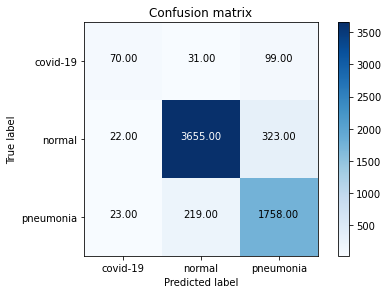

85 2220 3905
Accuracy = 92 %
              precision    recall  f1-score   support

           0       1.00      0.29      0.44        28
           1       0.94      0.97      0.96       400
           2       0.94      0.90      0.92       228

   micro avg       0.94      0.91      0.93       656
   macro avg       0.96      0.72      0.77       656
weighted avg       0.95      0.91      0.92       656
 samples avg       0.94      0.93      0.94       656

F1 score =  0.7730941704035875
[[[600   0]
  [ 20   8]]

 [[205  23]
  [ 13 387]]

 [[387  13]
  [ 23 205]]]
tensor([[  8.,  10.,  10.],
        [  0., 387.,  13.],
        [  0.,  13., 187.]])


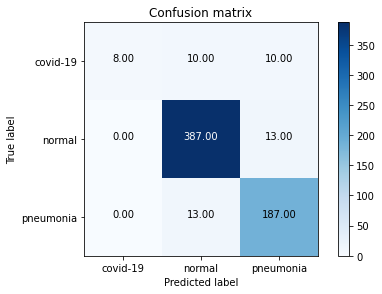

8 210 410


In [121]:

path   = '/content/drive/My Drive/Vgg16_CE_entire.pth'
model  = torch.load(path)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

actual , predict = feedforward(model,trainloader)

cm = confusion_mat(actual , predict )
plot_confusion_matrix(cm, class_names)

covid   =  np.where((predict[:,0] == 1 ) )
normal  =  np.where((predict[:,1] == 1 ) )
nemonia =  np.where((predict[:,0] == 0 ) & (predict[:,2] == 1 ))

print(len(covid[0]),len(nemonia[0]),len(normal[0]) )

actual , predict = feedforward(model,validloader)

cm = confusion_mat(actual , predict )
plot_confusion_matrix(cm, class_names)

covid   =  np.where((predict[:,0] == 1 ) )
normal  =  np.where((predict[:,1] == 1 ) )
nemonia =  np.where((predict[:,0] == 0 ) & (predict[:,2] == 1 ))

print(len(covid[0]),len(nemonia[0]),len(normal[0]) )

Accuracy = 90 %
              precision    recall  f1-score   support

           0       0.83      0.48      0.61       200
           1       0.93      0.95      0.94      4000
           2       0.91      0.87      0.89      2200

   micro avg       0.92      0.91      0.91      6400
   macro avg       0.89      0.77      0.81      6400
weighted avg       0.92      0.91      0.91      6400
 samples avg       0.92      0.92      0.92      6400

F1 score =  0.8117129212494141
[[[5980   20]
  [ 104   96]]

 [[1898  302]
  [ 187 3813]]

 [[3811  189]
  [ 293 1907]]]
tensor([[  99.,   30.,   71.],
        [  21., 3813.,  166.],
        [  22.,  271., 1707.]])


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


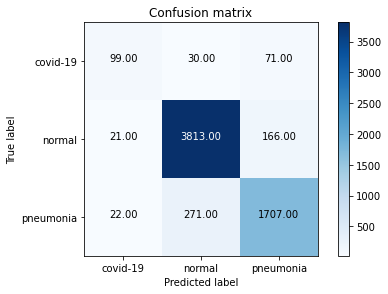

116 1982 4115
Accuracy = 92 %
              precision    recall  f1-score   support

           0       1.00      0.36      0.53        28
           1       0.94      0.97      0.96       400
           2       0.95      0.90      0.92       228

   micro avg       0.94      0.92      0.93       656
   macro avg       0.96      0.74      0.80       656
weighted avg       0.95      0.92      0.93       656
 samples avg       0.94      0.94      0.94       656

F1 score =  0.8018377228903545
[[[600   0]
  [ 18  10]]

 [[203  25]
  [ 11 389]]

 [[389  11]
  [ 23 205]]]
tensor([[ 10.,  10.,   8.],
        [  0., 389.,  11.],
        [  1.,  15., 184.]])


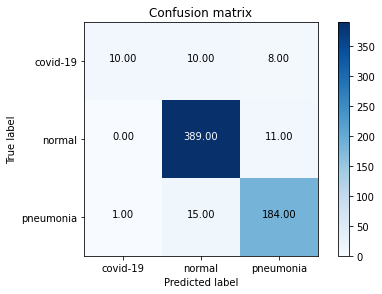

10 206 414


In [123]:

path   = '/content/drive/My Drive/Vgg16_FL_entire1.pth'
model  = torch.load(path)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

actual , predict = feedforward(model,trainloader)

cm = confusion_mat(actual , predict )
plot_confusion_matrix(cm, class_names)

covid   =  np.where((predict[:,0] == 1 ) )
normal  =  np.where((predict[:,1] == 1 ) )
nemonia =  np.where((predict[:,0] == 0 ) & (predict[:,2] == 1 ))

print(len(covid[0]),len(nemonia[0]),len(normal[0]) )

actual , predict = feedforward(model,validloader)

cm = confusion_mat(actual , predict )
plot_confusion_matrix(cm, class_names)

covid   =  np.where((predict[:,0] == 1 ) )
normal  =  np.where((predict[:,1] == 1 ) )
nemonia =  np.where((predict[:,0] == 0 ) & (predict[:,2] == 1 ))

print(len(covid[0]),len(nemonia[0]),len(normal[0]) )

Accuracy = 89 %
              precision    recall  f1-score   support

           0       0.74      0.33      0.46       200
           1       0.91      0.96      0.94      4000
           2       0.93      0.82      0.87      2200

   micro avg       0.91      0.89      0.90      6400
   macro avg       0.86      0.70      0.75      6400
weighted avg       0.91      0.89      0.90      6400
 samples avg       0.91      0.91      0.91      6400

F1 score =  0.7541940722899753
[[[5977   23]
  [ 134   66]]

 [[1814  386]
  [ 148 3852]]

 [[3860  140]
  [ 396 1804]]]
tensor([[  68.,   53.,   79.],
        [  14., 3852.,  134.],
        [  46.,  333., 1621.]])


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


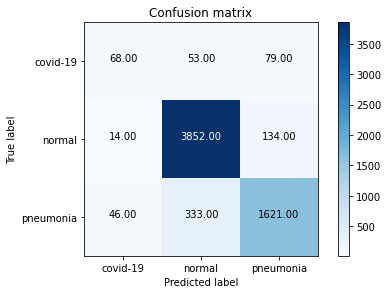

89 1855 4238
Accuracy = 92 %
              precision    recall  f1-score   support

           0       1.00      0.36      0.53        28
           1       0.92      0.98      0.95       400
           2       0.96      0.84      0.90       228

   micro avg       0.93      0.91      0.92       656
   macro avg       0.96      0.73      0.79       656
weighted avg       0.93      0.91      0.91       656
 samples avg       0.93      0.93      0.93       656

F1 score =  0.7905474428662096
[[[600   0]
  [ 18  10]]

 [[192  36]
  [  7 393]]

 [[392   8]
  [ 36 192]]]
tensor([[ 10.,  12.,   6.],
        [  0., 393.,   7.],
        [  0.,  24., 176.]])


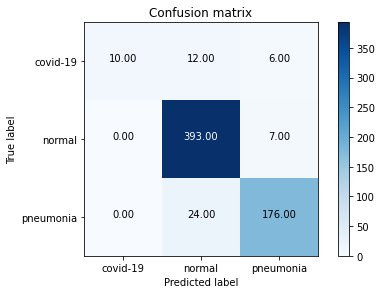

10 190 429


In [124]:

path   = '/content/drive/My Drive/Vgg16_FL_entire2.pth'
model  = torch.load(path)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

actual , predict = feedforward(model,trainloader)

cm = confusion_mat(actual , predict )
plot_confusion_matrix(cm, class_names)

covid   =  np.where((predict[:,0] == 1 ) )
normal  =  np.where((predict[:,1] == 1 ) )
nemonia =  np.where((predict[:,0] == 0 ) & (predict[:,2] == 1 ))

print(len(covid[0]),len(nemonia[0]),len(normal[0]) )

actual , predict = feedforward(model,validloader)

cm = confusion_mat(actual , predict )
plot_confusion_matrix(cm, class_names)

covid   =  np.where((predict[:,0] == 1 ) )
normal  =  np.where((predict[:,1] == 1 ) )
nemonia =  np.where((predict[:,0] == 0 ) & (predict[:,2] == 1 ))

print(len(covid[0]),len(nemonia[0]),len(normal[0]) )

Accuracy = 89 %
              precision    recall  f1-score   support

           0       0.68      0.41      0.51       200
           1       0.92      0.95      0.94      4000
           2       0.90      0.86      0.88      2200

   micro avg       0.91      0.90      0.91      6400
   macro avg       0.84      0.74      0.77      6400
weighted avg       0.91      0.90      0.90      6400
 samples avg       0.91      0.91      0.91      6400

F1 score =  0.7739079101638108
[[[5962   38]
  [ 119   81]]

 [[1893  307]
  [ 216 3784]]

 [[3795  205]
  [ 316 1884]]]
tensor([[  84.,   34.,   82.],
        [  32., 3784.,  184.],
        [  51.,  273., 1676.]])


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


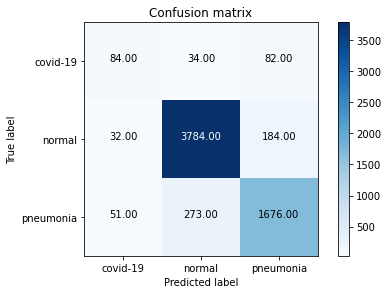

119 1970 4091
Accuracy = 92 %
              precision    recall  f1-score   support

           0       0.92      0.43      0.59        28
           1       0.94      0.97      0.96       400
           2       0.95      0.89      0.92       228

   micro avg       0.94      0.92      0.93       656
   macro avg       0.94      0.76      0.82       656
weighted avg       0.94      0.92      0.93       656
 samples avg       0.94      0.94      0.94       656

F1 score =  0.8205915766891376
[[[599   1]
  [ 16  12]]

 [[203  25]
  [ 11 389]]

 [[390  10]
  [ 25 203]]]
tensor([[ 13.,   8.,   7.],
        [  2., 389.,   9.],
        [  1.,  17., 182.]])


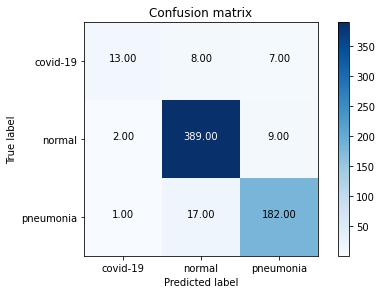

13 200 414


In [125]:

path   = '/content/drive/My Drive/Vgg16_FL_entire.pth'
model  = torch.load(path)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

actual , predict = feedforward(model,trainloader)

cm = confusion_mat(actual , predict )
plot_confusion_matrix(cm, class_names)

covid   =  np.where((predict[:,0] == 1 ) )
normal  =  np.where((predict[:,1] == 1 ) )
nemonia =  np.where((predict[:,0] == 0 ) & (predict[:,2] == 1 ))

print(len(covid[0]),len(nemonia[0]),len(normal[0]) )

actual , predict = feedforward(model,validloader)

cm = confusion_mat(actual , predict )
plot_confusion_matrix(cm, class_names)

covid   =  np.where((predict[:,0] == 1 ) )
normal  =  np.where((predict[:,1] == 1 ) )
nemonia =  np.where((predict[:,0] == 0 ) & (predict[:,2] == 1 ))

print(len(covid[0]),len(nemonia[0]),len(normal[0]) )

In [79]:

path   = '/content/drive/My Drive/Vgg16_FL_entire.pth'
model  = torch.load(path)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

actual , predict = feedforward(model,testloader)

covid   =  np.where((predict[:,0] == 1 ) )
normal  =  np.where((predict[:,1] == 1 ) )
nemonia =  np.where((predict[:,0] == 0 ) & (predict[:,2] == 1 ))
predict[:,[0, 1]] = predict[:,[1, 0]] # order of labels

print(len(covid[0]),len(nemonia[0]),len(normal[0]) )



19 202 407


In [102]:
imgs = []
for img in glob.glob('/content/drive/My Drive/A_05_Part_02_Dataset/Test/Test/*'):
  img = img[55:] # exclude path before name
  imgs.append(img)
imgs = np.array(imgs).astype('str')
imgs[:5]

array(['492.png', '9.jpg', '586.jpg', '512.jpg', '28.png'], dtype='<U7')

In [113]:
df = pd.DataFrame()
df[0] = imgs
df[1] = predict[:,0]
df[2] = predict[:,1]
df[3] = predict[:,2]
df.to_csv('results.csv', header=False, index=False)
df.head(5)

,0,1,2,3
0,492.png,1.0,0.0,0.0
1,9.jpg,1.0,0.0,0.0
2,586.jpg,1.0,0.0,0.0
3,512.jpg,0.0,0.0,1.0
4,28.png,1.0,0.0,0.0
